# Libraries

In [3]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# root = str(Path().resolve().parent)
custom_pkg = str(Path().resolve().parent.parent / "python")
if custom_pkg not in sys.path:
    sys.path.append(custom_pkg)
print(*sys.path, sep="\n")

# %matplotlib ipympl
%matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [4]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog, rf_tx_fw, tonegen, digital_filter_design, digital_hw_algo as dighw

reload(calc)
reload(ofdm)
reload(rf_analog)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(dighw)

<module 'rfdsppy.digital_hw_algo' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/digital_hw_algo.py'>

# Polyphase Decomposition

In [ ]:
# Prototype filter

M = 3
fp = 0.2
b = signal.firls(15, [0, fp, 2/M-fp, 1], [1, 1, 0, 0], fs=2)
b = b/b.sum()
b = np.round(b*(2**15-1))

print(b.astype("int"))

[  329   151  -816 -1597  -258  3956  8988 11262  8988  3956  -258 -1597
  -816   151   329]


In [ ]:
# Polyphase components

e = []
for i in range(M):
    e.append(b[i::M])

print(*e, sep="\n")

[  329. -1597.  8988.  3956.  -816.]
[  151.  -258. 11262.  -258.   151.]
[ -816.  3956.  8988. -1597.   329.]


In [26]:
# Reconstruct prototype filter

e_up = []
for i in range(M):
    e_up.append(np.concatenate((np.zeros(i), (dighw.upsample(e[i], M)))))

print(*e_up, sep="\n")

[  329.     0.     0. -1597.     0.     0.  8988.     0.     0.  3956.
     0.     0.  -816.     0.     0.]
[    0.   151.     0.     0.  -258.     0.     0. 11262.     0.     0.
  -258.     0.     0.   151.     0.     0.]
[    0.     0.  -816.     0.     0.  3956.     0.     0.  8988.     0.
     0. -1597.     0.     0.   329.     0.     0.]


In [33]:
e_up[2][:-2]

array([    0.,     0.,  -816.,     0.,     0.,  3956.,     0.,     0.,
        8988.,     0.,     0., -1597.,     0.,     0.,   329.])

[ -120     0   530     0 -2242     0  9992 16445  9992     0 -2242     0
   530     0  -120]
[ -889     0  1480     0 -3135     0 10536 16781 10536     0 -3135     0
  1480     0  -889]
[ -556     0  1330     0 -2999     0 10345 16528 10345     0 -2999     0
  1330     0  -556]


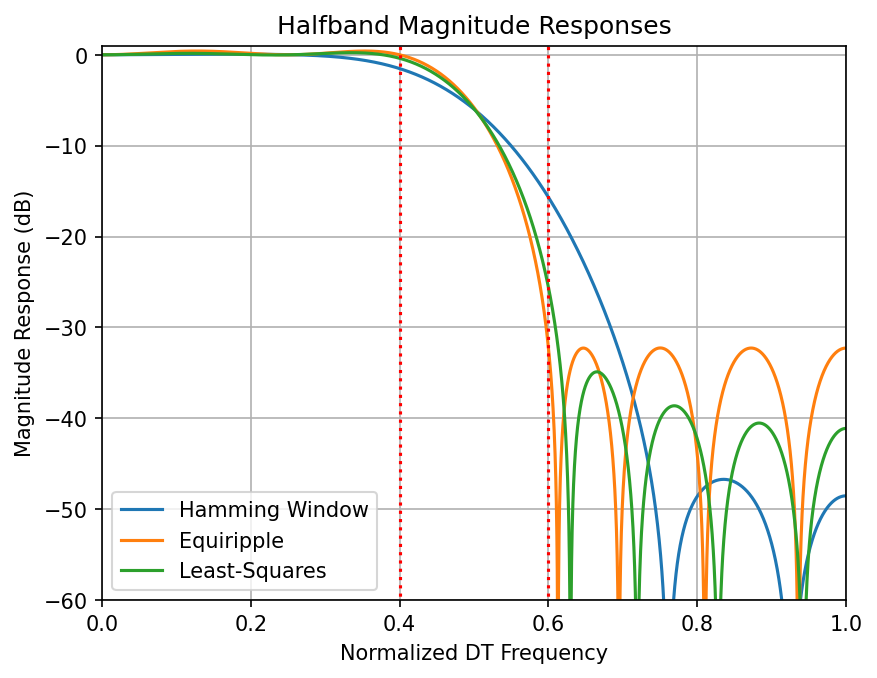

In [ ]:


b_ls = b_ls/b_ls.sum()
b_pm = b_pm/b_pm.sum()
b_win = b_win/b_win.sum()

fig, ax = plt.subplots(dpi=150)
w, h = signal.freqz(b_win, worN=4096, fs=2)
ax.plot(w, 20*np.log10(np.abs(h)), label="Hamming Window")
w, h = signal.freqz(b_pm, worN=4096, fs=2)
ax.plot(w, 20*np.log10(np.abs(h)), label="Equiripple")
w, h = signal.freqz(b_ls, worN=4096, fs=2)
ax.plot(w, 20*np.log10(np.abs(h)), label="Least-Squares")
ax.legend(loc="lower left")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=-60, top=1)
ax.vlines([0.4, 0.6], ymin=-100, ymax=100, colors='r', linestyles="dotted")
ax.set_title("Halfband Magnitude Responses")
ax.set_ylabel("Magnitude Response (dB)")
ax.set_xlabel("Normalized DT Frequency")
ax.grid()

print(np.round(b_win*(2**15-1)).astype("int"))
print(np.round(b_pm*(2**15-1)).astype("int"))
print(np.round(b_ls*(2**15-1)).astype("int"))